# Train and evaluate CNN models



Author: Akash Kharita

Date: 02/28/2024


Import modules

In [466]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import obspy
from tqdm import tqdm
from glob import glob
import random
import sys
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

from scipy import stats
from scipy import signal
from sklearn.preprocessing import StandardScaler

from obspy.geodetics.base import gps2dist_azimuth

from datetime import timedelta
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset

from scipy.signal import resample
# from zenodo_get import zenodo_get

## Importing all the models

In [ ]:

# from design_CNN_models import Archtime
# from design_CNN_models import Archtime_do
# from design_CNN_models import WaveDecompNet
# from design_CNN_models import WaveDecompNet_do
# from design_CNN_models import SeismicCNN_batch
# from design_CNN_models import SeismicCNN_batch_do
# from design_CNN_models import SeismicNet
# from design_CNN_models import SeismicNet_do


# from neural_network_processing_functions import extract_datasets
# from neural_network_processing_functions import train_model
# from neural_network_processing_functions import plot_train_val_loss
# from neural_network_processing_functions import plot_accuracy
# from neural_network_processing_functions import extract_datasets_for_test
# from neural_network_processing_functions import train_model_for_test
# from neural_network_processing_functions import test_model

## Parameters

### Waveform data

In [ ]:
#data files
file_noise="/data/whd01/yiyu_data/PNWML/noise_waveforms.hdf5";
file_comcat=  "/data/whd01/yiyu_data/PNWML/comcat_waveforms.hdf5";
file_exotic="/data/whd01/yiyu_data/PNWML/exotic_waveforms.hdf5";

### Waveform Metadata

In [330]:
# metadata
# accessing the comcat metadata
comcat_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")

# accessing the exotic metadata
exotic_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")

# accessing the data files
metadata_noise = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")

# creating individual data frames for each class
cat_exp = comcat_metadata[comcat_metadata['source_type'] == 'explosion']
cat_eq = comcat_metadata[comcat_metadata['source_type'] == 'earthquake']
cat_su = exotic_metadata[exotic_metadata['source_type'] == 'surface event']
cat_noise = metadata_noise
cat_noise['event_id'] = [cat_noise['trace_start_time'][i]+'_noise' for i in range(len(cat_noise))]


### Data Prep

In [460]:
start=-30
window_length=100 # in seconds
fs=50 # target sampling rate


number_data=100 # number of data samples per class
num_channels=3  # number of components to check

all_data=False
shifting=True


# training parameters
train_split = 80
val_split=10
test_split = 10


label_encoder = LabelEncoder()


## Additional functions

In [402]:
# defining a very simple CNN
        
class SeismicCNN(nn.Module):
    def __init__(self, num_classes=4, num_channels = 3):
        super(SeismicCNN, self).__init__()
        # Define the layers of the CNN architecture
        self.conv1 = nn.Conv1d(in_channels= num_channels, out_channels=8, kernel_size=9,stride=1,padding='same')
        self.conv2 = nn.Conv1d(in_channels= 8, out_channels=8, kernel_size=9,stride=2,padding=4)
        
        self.conv3 = nn.Conv1d(in_channels= 8, out_channels=16, kernel_size=7,stride=1,padding='same')
        self.conv4 = nn.Conv1d(in_channels= 16, out_channels=16, kernel_size=7,stride=2,padding=3)
        
        
        self.conv5 = nn.Conv1d(in_channels= 16, out_channels=32, kernel_size=5,stride=1,padding='same')
        self.conv6 = nn.Conv1d(in_channels= 32, out_channels=32, kernel_size=5,stride=2,padding=2)
        
        
        self.conv7 = nn.Conv1d(in_channels= 32, out_channels=64, kernel_size=3,stride=1,padding='same')
        
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # batch-normalization layers
        self.bn1 = nn.BatchNorm1d(8, dtype=torch.float64)
        self.bn2 = nn.BatchNorm1d(8, dtype=torch.float64)
        self.bn3 = nn.BatchNorm1d(16, dtype=torch.float64)
        self.bn4 = nn.BatchNorm1d(16, dtype=torch.float64)
        self.bn5 = nn.BatchNorm1d(32, dtype=torch.float64)
        self.bn6 = nn.BatchNorm1d(32, dtype=torch.float64)
        self.bn7 = nn.BatchNorm1d(64, dtype=torch.float64)
        
        self.fc1 = nn.Linear(4992, 128)  # Adjust input size based on your data
        self.fc1_bn = nn.BatchNorm1d(128)
        self.fc2_bn = nn.BatchNorm1d(num_classes)
        
        # define dropout
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x))) # feature extraction, output size of 8,5000
        x = self.pool1(F.relu(self.bn2(self.conv2(x)))) # feature extraction, output size of 8,1250 
        # max pooling is done at this point, but after the 2 convolutions to avoid aliasing
        x = F.relu(self.bn3(self.conv3(x))) # feature extraction, output size of 16,1250
        x = self.pool1(F.relu(self.bn4(self.conv4(x)))) # feature extraction, output size of 16, 312
        x =  F.relu(self.bn5(self.conv5(x))) # feature extraction, output size of 32, 312
        x = self.pool1(F.relu(self.bn6(self.conv6(x)))) # feature extraction, output size of 32, 78
        x = F.relu(self.bn7(self.conv7(x))) # feature extraction, output size of 64, 78            
        x = x.view(x.size(0), -1) # Flatten before fully connected layer, 4992 features!
        x = F.relu(self.fc1_bn(self.fc1()))  # classifier
        x = self.fc2_bn(self.fc2(x)) # classifier
        
        return x
    

    def calculate_num_features_after_conv(self):
        # Dummy input to calculate the number of features after convolutional layers
        dummy_input = torch.randn(1, self.num_channels, self.num_features)  # Adjust the size based on your input size
        with torch.no_grad():
            conv_output = self.forward_conv(dummy_input)
        num_features_after_conv = conv_output.view(1, -1).size(1)
        return num_features_after_conv   
    
    
    

In [494]:
model=SeismicCNN().to(device)
print(model)

SeismicCNN(
  (conv1): Conv1d(3, 8, kernel_size=(9,), stride=(1,), padding=same)
  (conv2): Conv1d(8, 8, kernel_size=(9,), stride=(2,), padding=(4,))
  (conv3): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=same)
  (conv4): Conv1d(16, 16, kernel_size=(7,), stride=(2,), padding=(3,))
  (conv5): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=same)
  (conv6): Conv1d(32, 32, kernel_size=(5,), stride=(2,), padding=(2,))
  (conv7): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=same)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine

In [503]:
# adding some more comments here
from torch.utils.data import Dataset
class PNWDataSet(Dataset): # create custom dataset
    def __init__(self, data,labels,num_classes): # initialize
        self.data = data 
        self.labels = labels
        self.num_classes = num_classes

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample_data = self.data[index]
        sample_labels = self.labels[index]
        
        
        # Convert labels to one-hot encoded vectors
        sample_labels = torch.nn.functional.one_hot(torch.tensor(sample_labels), num_classes=self.num_classes)
        print(sample_labels)
        return torch.Tensor(sample_data), sample_labels.float()  # return data as a tensor
    

In [448]:
import scipy.signal as signal
def extract_waveforms(cat, file_name, start=-20, input_window_length=100, fs=50, number_data=1000, num_channels=3, all_data=False, shifting=True):
    
    """
    This is a function defined to extract the waveforms from file of waveforms and a dataframe of metadata. 
    The functions will also filter and resample the data if the data sampling rate is different from the target sampling rate
    The data is shuffled in order it is called from the file it was stored in.
    The data is shuffled in time by allowing a shift in selecting the waveform window with some of the pre-P data.
    The data us normalized to its max(abs) on either component.
    
    Inputs:
    cat -  Catalog containing metadata of the events, so we can extract the data using the bucket information
    file_name - path of the h5py file containing the data
    start - origin or first arrival time
    num_features - window length to extract
    before - number of samples to take before the arrival time
    after - number of samples to take after the arrival time.
    num_samples - no. of events per class to extract
    
    input_window_length: desired window length in seconds
    fs: desired sampling rate.
    num_channels - no. of channels per event to extract, if set 1, will extract Z component, if set any other number, will extract - ZNE component. 
    all_samples - if true, will extract all the samples corresponding of a given class
    shifting - if true, will extract windows randomly starting between P-5, P-20. The random numbers follow a gaussian distribution. 
    Outputs:
    
    """   
    cat = cat.sample(frac=1).reset_index(drop=True)
    print(all_data,number_data,len(cat))
    if all_data:number_data = len(cat) # how many data to include
    # open the file
    f = h5py.File(file_name, 'r')
    x=np.zeros(shape=(number_data,3,int(fs*window_length)))
    event_ids = cat['event_id'].values
    if not all_data:event_ids=event_ids[:number_data]
        
    for index in range(number_data):
        # read data
        bucket, narray = cat.loc[index]['trace_name'].split('$')
        xx, _, _ = iter([int(i) for i in narray.split(',:')])
        data = f['/data/%s' % bucket][xx, :, : ] # get all of the data
        if fs != cat.loc[index,'trace_sampling_rate_hz']: #resample the data
            nyquist = 0.5 * cat.loc[index,'trace_sampling_rate_hz']
            low = 0.05 / nyquist;  high = 20 / nyquist
            b, a = signal.butter(4, [low, high], btype='band')

            # Apply the taper+filter to the signal
            taper = signal.windows.tukey(data.shape[-1],alpha=0.1)
            data = np.array([np.multiply(taper,row) for row in data])
            filtered_signal = np.array([signal.filtfilt(b, a, row) for row in data])

            # resample
            number_of_samples = int(filtered_signal.shape[1] * fs / cat.loc[index,'trace_sampling_rate_hz'])
            data = np.array([signal.resample(row, number_of_samples) for row in filtered_signal])

            
        if event_ids[index].split("_")[-1]!="noise":
            #random start between P-20 and P-5 (upper bound is exclusive in numpy.random.randint)        
            ii = int(np.random.randint(start,-4)*fs)
            
            if np.isnan(cat.loc[index, 'trace_P_arrival_sample']):continue
            
            istart = int(cat.loc[index, 'trace_P_arrival_sample']*fs/cat.loc[index,'trace_sampling_rate_hz']) + ii # start around the P
            iend  = istart + int(fs*window_length)
            if iend>data.shape[-1]:
                istart = istart - (iend-data.shape[-1])
                iend = data.shape[-1]
        else:
            istart=0
            iend=istart+int(fs*window_length)

        
        # normalize the data
        mmax = np.max(np.abs(data[:,istart:iend]))
        # store data in big index
        x[index,:,:iend-istart] = data[:,istart:iend]/mmax
        
        if num_channels==1:
            x2 = x[:,2,:]
            del x
            x = x2
            
    print(np.mean(np.abs(x[:,2,0:10]),axis=-1))
    # remove rows with zeros if there are any
    idx=np.where(np.mean(np.abs(x[:,2,0:10]),axis=-1)>0)[0]
                     
    
    f.close()
    return x[idx,:,:], event_ids[idx]


In [487]:
def train_model(model, train_loader, val_loader,  n_epochs=100, batch_size=32,learning_rate=0.001,criterion=nn.CrossEntropyLoss()):
    """
    Function to train and evaluate the defined model.

    Parameters:
        model (torch.nn.Module): The neural network model.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        val_dataset (torch.utils.data.Dataset): Validation dataset.
        val_loader (torch.utils.data.DataLoader): DataLoader for validation data.
        optimizer (torch.optim.Optimizer): Optimizer for training the model.
        n_epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        number_input (int): Number of points in the input data.
        num_channels (int): Number of channels in the input data.

    Returns:
        accuracy_list (list): List of accuracies computed from each epoch.
        train_loss_list (list): List of training losses from each epoch.
        val_loss_list (list): List of validation losses from each epoch.
        y_pred (list): List of predicted values.
        y_true (list): List of true values.
    """
    # Check if a GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model = model.to(device)
    N_test = len(val_dataset)

    # to store the accuracies computed from each epoch.
#     accuracy_list = []

    # # Save loss and error for plotting
    loss_time = np.zeros(n_epochs)
    accuracy_time = np.zeros(n_epochs)

    # to store the predicted values
#     y_pred = []
#     y_true = []

    for epoch in range(n_epochs):
        running_loss = 0
        for data in train_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            inputs = inputs.float()
            labels = labels.long()
            
            
            # Set the parameter gradients to zero
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            
            # computing the gradients
            loss.backward()

            # updating the parameters
            optimizer.step()

            running_loss += loss.item()

        # updating the training loss list
        loss_time[epoch] = running_loss/len(trainloader)

             # We evaluate the model, so we do not need the gradient
        with torch.no_grad(): # Context-manager that disabled gradient calculation.
            # Loop on samples in test set
            for data in trainloader:
                # Get the sample and modify the format for PyTorch
                inputs, labels = data[0].to(device), data[1].to(device)
                inputs = inputs.float() 
                labels = labels.long()
                # Use model for sample in the test set
                outputs = model(inputs)
                # Compare predicted label and true label
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        # Save error at the end of each epochs
        accuracy_time[epoch] = 100 * correct / total

    # Print intermediate results on screen
    if testloader is not None:
        print('[Epoch %d] loss: %.3f - accuracy: %.3f' %
          (epoch + 1, running_loss/len(trainloader), 100 * correct / total))
    else:
        print('[Epoch %d] loss: %.3f' %
          (epoch + 1, running_loss/len(trainloader)))

    return loss_time, accuracy_time



## Select only high SNR data

based on the SNR value in the Z component, then store the reduced panda dataframe for each class.

In [331]:
# explosions
trace_snr_db_values = np.array([float(cat_exp.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_exp.index.values.tolist()])
ii2= np.where(trace_snr_db_values>18)[0].astype(int) 
df_exp = cat_exp.iloc[ii2]

# earthquake
trace_snr_db_values = np.array([float(cat_eq.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_eq.index.values.tolist()])
ii2= np.where(trace_snr_db_values>18)[0].astype(int) 
df_eq = cat_eq.iloc[ii2]

# surface events
trace_snr_db_values = np.array([float(cat_su.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_su.index.values.tolist()])
ii2= np.where(trace_snr_db_values>18)[0].astype(int) 
df_su = cat_su.iloc[ii2]

# noise
# does not change
df_noise = cat_noise

In [332]:
df_noise.head()

,source_type,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time,event_id
0,noise,UW,BH,TTW,--,47.694,-121.690,542.0,"bucket1$0,:3,:15001",100,2002-09-21T00:50:20.960000Z,2002-09-21T00:50:20.960000Z_noise
1,noise,UW,HH,ERW,--,48.454,-122.626,387.0,"bucket2$0,:3,:15001",100,2002-09-21T00:50:20.960000Z,2002-09-21T00:50:20.960000Z_noise
2,noise,UW,BH,GNW,--,47.564,-122.825,220.0,"bucket3$0,:3,:15001",100,2002-09-21T00:50:20.960000Z,2002-09-21T00:50:20.960000Z_noise
3,noise,UW,BH,OPC,--,48.100,-123.413,90.0,"bucket4$0,:3,:15001",100,2002-09-21T00:50:20.960000Z,2002-09-21T00:50:20.960000Z_noise
4,noise,UW,BH,GNW,--,47.564,-122.825,220.0,"bucket5$0,:3,:15001",100,2002-09-13T14:54:54.050000Z,2002-09-13T14:54:54.050000Z_noise


In [353]:


f.close()


In [445]:
d_su, id_su = extract_waveforms(df_su, file_exotic, input_window_length = input_window_length, fs=fs,
                                start =start, number_data = number_data_per_class, num_channels = num_channels,
                                shifting = shifting, all_data = False)


False 100 2663
[0.01154793 0.01005704 0.00217112 0.00152541 0.00609328 0.00953464
 0.01225048 0.00055511 0.00340056 0.0092595  0.00231001 0.01297391
 0.00589095 0.00241998 0.0125669  0.00147184 0.00082514 0.00373033
 0.00538786 0.00152172 0.00494315 0.00385121 0.0042861  0.01416474
 0.00443752 0.00221131 0.00152669 0.00564976 0.0176022  0.01699009
 0.00218495 0.00589432 0.0257209  0.00466626 0.00301802 0.00288546
 0.00108447 0.01511096 0.00129634 0.00105155 0.00228756 0.00704934
 0.00141264 0.00049907 0.00246431 0.0174376  0.00942561 0.00132663
 0.0066774  0.0012657  0.00744667 0.01470502 0.00347212 0.00071597
 0.00156617 0.0011096  0.01036634 0.00431097 0.00629325 0.00142828
 0.00197723 0.00504757 0.00787649 0.00127869 0.00407104 0.00202469
 0.0179317  0.00370331 0.00416585 0.00189857 0.00097702 0.00043361
 0.01057134 0.01072328 0.00449552 0.00795605 0.00174669 0.00361601
 0.01283343 0.00876985 0.0155846  0.00635021 0.00198384 0.00121181
 0.00250306 0.00579305 0.00458631 0.00133056 0.

In [447]:
d_su.shape

(100, 3, 5000)

In [452]:
d_noise, id_noise = extract_waveforms(df_noise, file_noise, input_window_length = input_window_length, fs=fs,
                                      start = start, number_data = number_data_per_class,
                                      num_channels = num_channels, shifting = shifting, all_data = all_data)
print(d_noise.shape)

False 100 51462
[1.50382301e-02 1.13523047e-02 2.18125106e-02 3.10416763e-03
 3.71428959e-02 1.80390238e-02 2.47950201e-02 9.91500140e-02
 2.40325842e-02 3.43673323e-02 9.44137357e-02 2.70057405e-02
 5.40060457e-03 1.52166775e-02 9.99107448e-02 9.49323076e-02
 1.29933433e-02 6.26094182e-02 1.08008567e-01 7.88964098e-03
 5.69185882e-02 7.71558756e-02 3.01360547e-02 1.73775832e-02
 1.32872102e-02 2.69842041e-02 4.54334788e-02 1.83891537e-02
 2.14232345e-02 2.30666361e-02 3.62756210e-02 3.54348043e-02
 1.05692439e-02 2.32851960e-02 2.07670530e-03 3.61257306e-02
 1.64422311e-02 1.82237830e-03 5.39439810e-02 2.14533211e-03
 1.42091933e-02 1.30752204e-02 6.90013998e-02 1.39149124e-02
 1.79280794e-02 3.46099159e-02 6.89137111e-03 7.35393736e-02
 1.54416146e-01 4.58215471e-03 2.68814270e-02 4.06678725e-03
 5.78695017e-02 7.18455036e-02 3.16566921e-02 1.74026789e-02
 7.01190332e-02 2.53652812e-02 6.71884598e-02 4.16685311e-02
 4.37279141e-02 7.14834287e-03 7.85868622e-03 2.40921800e-02
 1.97822

In [453]:

d_exp, id_exp = extract_waveforms(df_exp, file_comcat, input_window_length = input_window_length, fs=fs,
                                  start = start,  number_data = number_data_per_class, num_channels = num_channels,
                                  shifting = shifting, all_data = all_data)

print(d_exp.shape)

False 100 3289
[0.01655496 0.02282861 0.00579767 0.00721168 0.00524474 0.01232129
 0.01260098 0.01255255 0.02324492 0.00478521 0.02741326 0.00801647
 0.00347299 0.02555732 0.01890751 0.00808336 0.01744012 0.0067659
 0.04694972 0.0012035  0.02891199 0.01101531 0.01902789 0.00465506
 0.03382357 0.00448122 0.00595575 0.00149044 0.00895882 0.0115871
 0.00382188 0.01497986 0.0086028  0.00910063 0.00547861 0.01794833
 0.00907307 0.0099763  0.00124594 0.01174059 0.00682416 0.02556843
 0.00675152 0.04682315 0.00323502 0.00170395 0.01395976 0.0015345
 0.01208453 0.01494545 0.01457824 0.00860959 0.02223142 0.00991746
 0.00158946 0.01212015 0.01697756 0.00940476 0.02078822 0.00974871
 0.01179273 0.00977171 0.01104726 0.00184313 0.00679694 0.0037499
 0.0142575  0.0084233  0.00067359 0.08563105 0.01086453 0.00128396
 0.00160456 0.00671947 0.01605011 0.00313883 0.00947052 0.01708835
 0.02359235 0.01316818 0.00292997 0.01203835 0.0217423  0.01968064
 0.00357981 0.00935939 0.00736416 0.00910313 0.0056

In [462]:
d_eq, id_eq = extract_waveforms(df_eq, file_comcat, input_window_length = input_window_length,  fs=fs,
                                start =start,  number_data = number_data_per_class, num_channels = num_channels,
                                shifting = shifting, all_data = all_data)

False 100 52724
[0.00930136 0.0097727  0.00142361 0.00236151 0.01232287 0.02768399
 0.01669156 0.00375692 0.00573741 0.0325912  0.01495823 0.00299302
 0.00104336 0.03170303 0.00197763 0.01435938 0.01078069 0.00940674
 0.01211332 0.02486089 0.01890498 0.00372999 0.03734352 0.00150848
 0.01820651 0.02353886 0.00929611 0.00823387 0.01232683 0.00158877
 0.01186769 0.01190338 0.00783574 0.00139728 0.00051891 0.0018104
 0.00475882 0.03736479 0.00904528 0.00929827 0.02774364 0.00306573
 0.00851511 0.0092272  0.02211742 0.00327089 0.00119072 0.00163516
 0.00283636 0.00674526 0.00594131 0.00831639 0.05316163 0.00381468
 0.00989603 0.00073557 0.02733452 0.00746186 0.00590762 0.0303351
 0.00522615 0.00222968 0.0016139  0.00175092 0.01732238 0.01120399
 0.02264485 0.02213339 0.03489406 0.01414258 0.00910585 0.00282507
 0.01136823 0.01628075 0.00690106 0.01126336 0.00184241 0.02913961
 0.00405491 0.01192323 0.00961506 0.00904983 0.00203006 0.00707715
 0.00516147 0.00520859 0.00183088 0.00335323 0.0

(400, 3, 5000)


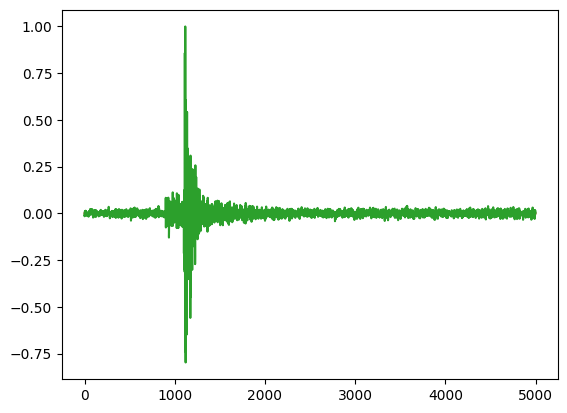

In [463]:
X = np.vstack([d_noise, d_exp, d_eq, d_su])
print(X.shape)
plt.plot(X[200,:,:].T)
plt.show()


## Prepare labels

In [508]:
# labels to encode   
event_ids = ['noise']*len(d_noise)+['explosion']*len(d_exp)+['earthquake']*len(d_eq)+['surface']*len(d_su)
event_ids = [0]*len(d_noise)+[1]*len(d_exp)+[2]*len(d_eq)+[3]*len(d_su)
# y = np.hstack([id_noise, id_exp, id_eq, id_su])
y = event_ids
print(y)
# y_encoded = label_encoder.fit_transform(y)
# print(y_encoded)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

In [509]:
custom_dataset = PNWDataSet(X,y,4)
for data,y in custom_dataset:
    print(data)

tensor([1, 0, 0, 0])
tensor([[ 0.0097,  0.0130,  0.0120,  ..., -0.1203, -0.1303, -0.1357],
        [-0.0098, -0.0139, -0.0127,  ...,  0.2990,  0.3122,  0.3185],
        [-0.0113, -0.0161, -0.0146,  ...,  0.1345,  0.1349,  0.1326]])
tensor([1, 0, 0, 0])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0083,  0.0118,  0.0108,  ..., -0.1262, -0.0350, -0.0073]])
tensor([1, 0, 0, 0])
tensor([[-0.0069, -0.0093, -0.0086,  ..., -0.0507, -0.0459, -0.0275],
        [-0.0373, -0.0486, -0.0454,  ...,  0.0583,  0.0470,  0.0154],
        [ 0.0190,  0.0216,  0.0211,  ...,  0.2036,  0.2068,  0.2211]])
tensor([1, 0, 0, 0])
tensor([[ 0.0106,  0.0174,  0.0153,  ...,  0.0955,  0.0398, -0.0346],
        [ 0.0020,  0.0009,  0.0010,  ..., -0.0661, -0.0203, -0.1952],
        [-0.0032, -0.0031, -0.0031,  ...,  0.0324,  0.2906,  0.2986]])
tensor([1, 0, 0, 0])
tensor([[ 0.0029,  0.0044,  0.0039,  ...,  0.0935, 

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0116,  0.0166,  0.0075,  ..., -0.0002, -0.0003, -0.0001]])
tensor([0, 1, 0, 0])
tensor([[-0.0218, -0.0212, -0.0211,  ..., -0.0272, -0.0272, -0.0284],
        [ 0.0068,  0.0078,  0.0068,  ..., -0.0101, -0.0071, -0.0042],
        [ 0.0218,  0.0225,  0.0234,  ...,  0.0298,  0.0308,  0.0304]])
tensor([0, 1, 0, 0])
tensor([[ 0.0014,  0.0053,  0.0040,  ..., -0.0012, -0.0057, -0.0054],
        [ 0.0006,  0.0019,  0.0029,  ..., -0.0025, -0.0036, -0.0007],
        [ 0.0038, -0.0025, -0.0068,  ..., -0.0027, -0.0032, -0.0030]])
tensor([0, 1, 0, 0])
tensor([[-0.0154, -0.0066, -0.0102,  ..., -0.0228, -0.0099,  0.0001],
        [ 0.0051, -0.0015, -0.0006,  ..., -0.0081,  0.0011,  0.0107],
        [ 0.0301,  0.0275,  0.0211,  ..., -0.0085,  0.0023, -0.0098]])
tensor([0, 1, 0, 0])
tensor([[-0.0075,  0.0022,  0.0047,  ..., -0.0034, -0.0016,  0.0006],
  

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0401,  0.0183, -0.0165,  ...,  0.0103,  0.0008, -0.0203]])
tensor([0, 0, 0, 1])
tensor([[ 2.5617e-04,  4.2022e-04,  1.3045e-04,  ..., -4.0007e-03,
         -4.4715e-03, -4.3980e-03],
        [-4.4988e-05, -9.0817e-03, -3.4438e-02,  ...,  5.4091e-02,
          9.0525e-02,  6.7339e-02],
        [-1.5135e-02, -1.5477e-02, -1.5542e-02,  ...,  2.9180e-03,
          5.4045e-03, -3.9860e-04]])
tensor([0, 0, 0, 1])
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0003, 0.0005, 0.0020,  ..., 0.0002, 0.0005, 0.0002]])
tensor([0, 0, 0, 1])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0073, -0.0102,  0.0028,  ..., -0.1329, -0.0215,  0.0769]])
tensor([0, 0

## Shuffle and split data

In [510]:
# Make the data a PNWDataSet
custom_dataset = PNWDataSet(X,y,4)
# first split train+val
# Determine the size of the training set
train_size = int(train_split/100 * len(custom_dataset)) # 80% of the data set
val_size = int(val_split/100 * len(custom_dataset)) # 10% of the data set
test_size = int(test_split/100 * len(custom_dataset)) # 10% of the data set
print(train_size,val_size,test_size)
train_dataset, val_dataset = random_split(custom_dataset, [train_size, test_size+val_size])
# then split val into val+test
test_dataset, val_dataset = random_split(val_dataset, [test_size,val_size])

320 40 40


In [511]:
for batch_data, batch_labels in custom_dataset:
    batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
    print(batch_labels)

/tmp/ipykernel_3015940/1998156415.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sample_labels = torch.nn.functional.one_hot(torch.tensor(sample_labels), num_classes=self.num_classes)


RuntimeError: one_hot is only applicable to index tensor.

## Defining some common parameters for all models

In [478]:
number_epochs = 100
# Define the loss function (e.g., Cross-Entropy)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Training and Testing all the models

In [497]:
(loss, accuracy) = train_model(model,train_dataset,val_dataset)

TypeError: new(): invalid data type 'str'

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(1, 101), loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Correct predictions', color=color)
ax2.plot(np.arange(1, 101), accuracy, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

## Archtime (Original)

In [ ]:
# Archtime_normal
num_channels = 1
number_features = 5000

#train_dataset, train_loader, test_dataset, test_loader, val_dataset, val_loader = extract_datasets(num_channels = 1, num_samples = 5000)
#train_dataset, train_loader, y_train, test_dataset, test_loader, y_test,  val_dataset, val_loader, y_val = extract_datasets(before = 1000, after = 40000, num_samples = 5000, batch_size = 32, num_channels = 1, train_size = 4000, test_size = 0, num_features = 5000, shifting = True)


data_loader_train,data_loader_val,data_loader_test = prepare_datasets()


# train_dataset, train_loader, y_train, test_dataset, test_loader, y_test,  val_dataset, val_loader, y_val, event_ids_normal = extract_datasets(before = 1000, after = 4000, num_samples = 5500, batch_size = 32, num_channels = 1, train_size = 5000, test_size = 1, num_features = 5000, shifting = True, all_samples = False)


model_archtime = Archtime(num_channels = 3, num_input = 5000)


optimizer = torch.optim.Adam(model_archtime.parameters(), lr=0.001)
accuracy_archtime, train_loss_archtime, val_loss_archtime, y_pred, y_true  = train_model(model_archtime, train_loader, val_dataset, val_loader, optimizer, n_epochs = number_epochs, num_channels = num_channels, num_features = 5000)
